In [304]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mstats
import statsmodels.api as sm

In [305]:
url = 'https://media.githubusercontent.com/media/musanchez/DataSets/refs/heads/main/realtor-data.csv'
df = pd.read_csv(url)

df.head() # Verificamos que el dataset se haya cargado correctamente


,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.00,for_sale,105000.00,3.00,2.00,0.12,1962661.00,Adjuntas,Puerto Rico,601.00,920.00,NaN
1,52707.00,for_sale,80000.00,4.00,2.00,0.08,1902874.00,Adjuntas,Puerto Rico,601.00,1527.00,NaN
2,103379.00,for_sale,67000.00,2.00,1.00,0.15,1404990.00,Juana Diaz,Puerto Rico,795.00,748.00,NaN
3,31239.00,for_sale,145000.00,4.00,2.00,0.10,1947675.00,Ponce,Puerto Rico,731.00,1800.00,NaN
4,34632.00,for_sale,65000.00,6.00,2.00,0.05,331151.00,Mayaguez,Puerto Rico,680.00,NaN,NaN


Información general del dataset:


,brokered_by,price,bed,bath,acre_lot,street,zip_code,house_size
count,2221849.00,2224841.00,1745065.00,1714611.00,1900793.00,2215516.00,2226083.00,1657898.00
mean,52939.89,524195.52,3.28,2.50,15.22,1012324.92,52186.68,2714.47
std,30642.75,2138893.22,1.57,1.65,762.82,583763.48,28954.08,808163.52
min,0.00,0.00,1.00,1.00,0.00,0.00,0.00,4.00
25%,23861.00,165000.00,3.00,2.00,0.15,506312.75,29617.00,1300.00
50%,52884.00,325000.00,3.00,2.00,0.26,1012765.50,48382.00,1760.00
75%,79183.00,550000.00,4.00,3.00,0.98,1521173.25,78070.00,2413.00
max,110142.00,2147483600.00,473.00,830.00,100000.00,2001357.00,99999.00,1040400400.00


Valores nulos en cantidad:
brokered_by         4533
status                 0
price               1541
bed               481317
bath              511771
acre_lot          325589
street             10866
city                1407
state                  8
zip_code             299
house_size        568484
prev_sold_date    734297
dtype: int64
Valores nulos en porcentaje:
brokered_by       0.20
status            0.00
price             0.07
bed              21.62
bath             22.99
acre_lot         14.62
street            0.49
city              0.06
state             0.00
zip_code          0.01
house_size       25.53
prev_sold_date   32.98
dtype: float64


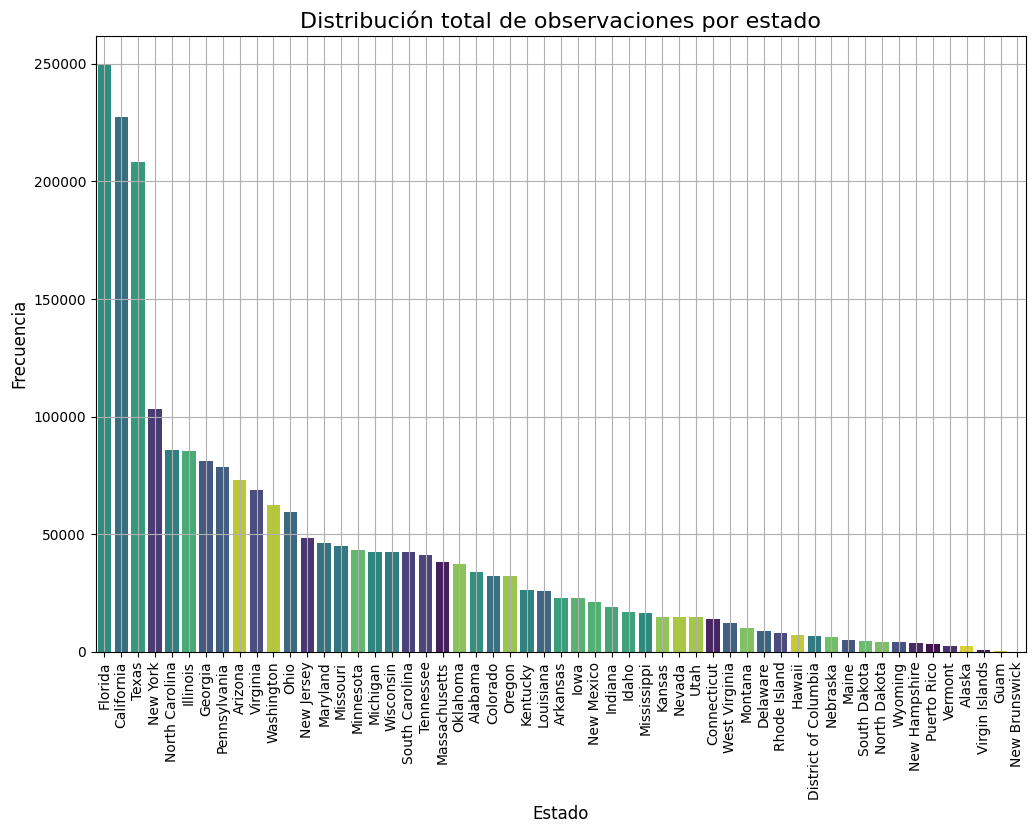

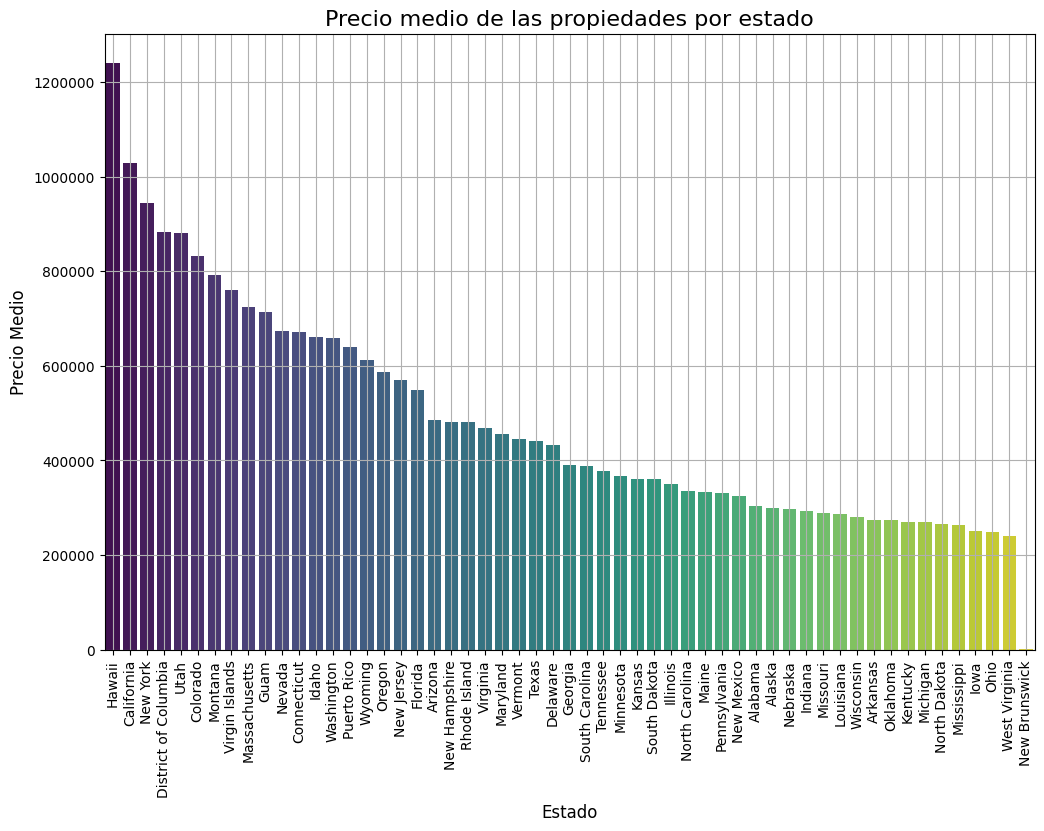

In [306]:
# Estadísticas descriptivas
# Evita que aparezcan los exponenciales y poder apreciar mejor el dataset
def set_overview(df):
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    print('Información general del dataset:')
    display(df.describe())
    print('Valores nulos en cantidad:')
    print(df.isna().sum()) # Verificamos si hay datos nulos
    print('Valores nulos en porcentaje:')
    print(df.isna().mean() * 100) # Observamos de manera porcentual los datos nulos

# Haremos un grafico de caja para cada variable numérica, le pasaremos el dataframe y todas las variables numéricas
def box_plot_vars(df):
    # Filtrar automáticamente solo las columnas numéricas
    numeric_vars = df.select_dtypes(include=['number']).columns
    
    # Definir el tamaño de la cuadrícula según el número de variables numéricas
    num_vars = len(numeric_vars)
    num_cols = 3  # Número de columnas en la cuadrícula
    num_rows = (num_vars + num_cols - 1) // num_cols  # Calcula las filas necesarias
    
    # Crear el grid de subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    axes = axes.flatten()  # Aplana la cuadrícula de ejes
    
    for i, var in enumerate(numeric_vars):
        sns.boxplot(x=df[var], ax=axes[i], color='lightblue', 
                    flierprops={'marker':'o', 'markerfacecolor':'red', 'markersize':8})
        
        # Título y etiquetas
        axes[i].set_title(f'Box Plot de {var}', fontsize=16)  # Agregar título con el nombre de la variable
        axes[i].set_xlabel(var, fontsize=12)  # Etiqueta del eje X
        axes[i].set_ylabel('Valores', fontsize=12)  # Etiqueta del eje Y
        
        # Quitar notación científica en el eje X
        axes[i].ticklabel_format(style='plain', axis='x')
        axes[i].grid(True)  # Añadir rejilla

        # Rotar las etiquetas del eje X para evitar traslapes
        for tick in axes[i].get_xticklabels():
            tick.set_rotation(45)  # Ajusta el ángulo de rotación a 45 grados
    
    # Eliminar cualquier gráfico vacío si es que sobran ejes
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()  # Ajustar los gráficos para que no se solapen
    plt.show()

def remove_outliers_iqr(df, column_name):

    if isinstance(df[column_name], np.ma.MaskedArray):
        df[column_name] = df[column_name].data

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df[column_name] >= (Q1 - 1.5 * IQR)) & (df[column_name] <= (Q3 + 1.5 * IQR))]
    return df

def plot_correlation_matrix(df):
    df_numeric = df.select_dtypes(include=['number'])
    
    plt.figure(figsize=(10, 8))
    correlation_matrix = df_numeric.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Matriz de correlación', fontsize=16)
    plt.show()

def plot_histograms(df, columns):
    for col in columns:
        plt.figure(figsize=(8, 6))
        sns.histplot(df[col], kde=True, color='skyblue')
        plt.title(f'Distribución de {col}', fontsize=16)
        plt.xlabel(col, fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.grid(True)
        plt.show()

def plot_state_distribution(df, column, title):
    plt.figure(figsize=(12, 8))
    sns.countplot(data=df, x=column, hue=column, order=df[column].value_counts().index, palette='viridis', dodge=False)
    plt.title(title, fontsize=16)
    plt.xlabel('Estado', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.legend([], [], frameon=False)  # Ocultar leyenda
    plt.show()

def plot_average_price_per_state(df):
    avg_price_per_state = df.groupby('state')['price'].mean().reset_index()
    avg_price_per_state = avg_price_per_state.sort_values(by='price', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(data=avg_price_per_state, x='state', y='price', hue='state', palette='viridis', dodge=False)
    plt.title('Precio medio de las propiedades por estado', fontsize=16)
    plt.xlabel('Estado', fontsize=12)
    plt.ylabel('Precio Medio', fontsize=12)
    plt.xticks(rotation=90)
    plt.ticklabel_format(style='plain', axis='y')  # Quitar notación científica en el eje Y
    plt.grid(True)
    plt.legend([], [], frameon=False)  # Ocultar leyenda
    plt.show()

def remove_outliers_zscore(df, column_name, threshold):
    z_scores = np.abs((df[column_name] - df[column_name].mean()) / df[column_name].std())
    df = df[(z_scores < threshold)]
    return df


def fit_ols_wls(X, y, weights):
    X_clean = X.astype(float).dropna()
    y_clean = y.loc[X_clean.index].dropna()
    
    # Agregar una constante a X
    X_sm = sm.add_constant(X_clean)

    # Ajustar el modelo WLS
    model_wls = sm.WLS(y_clean, X_sm, weights=weights.loc[X_clean.index]).fit()
    
    # Ajustar el modelo OLS
    model_ols = sm.OLS(y_clean, X_sm).fit()
    
    # Imprimir el resumen de los modelos
    print(f"Resumen WLS:\n", model_wls.summary())
    print(f"Resumen OLS:\n", model_ols.summary())

set_overview(df)
plot_state_distribution(df, 'state', 'Distribución total de observaciones por estado')
plot_average_price_per_state(df)
#Observamos de manera porcentual los datos nulos
# Las columnas brokered by, street, zip_code realmente no aportan información relevante para el análisis.
# Notamos datos extraños, por ejemplo, bed es el número de habitaciones y el valor máximo es de 473, sin sentido.
# Lo mismo podemos notar en el caso de bath, que es el número de baños y el valor máximo es de 830.

In [307]:
# Limpieza de datos

# Eliminamos registros de casas sin precio
df_cleaned = df.dropna(subset=['price']).copy()
df_cleaned.drop_duplicates(inplace=True)

df_cleaned['prev_sold_date'] = df_cleaned['prev_sold_date'].fillna('Not sold before')

df_cleaned = df_cleaned.drop(columns=['brokered_by', 'street', 'zip_code'])

# Eliminamos columnas que tengan demasiados valores nulos
df_cleaned = df_cleaned[df_cleaned.isna().sum(axis=1) < 0.5 * len(df_cleaned.columns)]

# Asigna la cantidad de baños promedios por cantidad de habitaciones
# Hacemos esto para la limpieza, así imputar valores faltantes.
bath_avg_bed = df.groupby('bed')['bath'].mean().round(0).reset_index()
bath_avg_bed.columns = ['bed', 'bath_avg']

# Vamos a llenar los valores faltantes de bath con el promedio de baños por cantidad de habitaciones
# Agregamos al cleaned set la columna con el promedio de baños por cantidad de habitaciones
df_cleaned = df_cleaned.merge(bath_avg_bed, on='bed', how='left')
df_cleaned['bath'] = df_cleaned['bath'].fillna(df_cleaned['bath_avg'])

# Eliminamos la columna de promedio de baños por cantidad de habitaciones, ya no se necesita
df_cleaned = df_cleaned.drop(columns='bath_avg')

# Imputamos valores faltantes en bed
df_cleaned = df_cleaned.fillna(df_cleaned['bed'].median())

set_overview(df_cleaned)


Información general del dataset:


,price,bed,bath,acre_lot,house_size
count,2224832.00,2224832.00,2224832.00,2224832.00,2224832.00
mean,524186.41,3.22,2.61,13.43,2022.72
std,2138839.50,1.39,1.48,705.06,697638.00
min,0.00,1.00,1.00,0.00,3.00
25%,165000.00,3.00,2.00,0.17,3.00
50%,325000.00,3.00,3.00,0.35,1442.00
75%,550000.00,4.00,3.00,3.00,2140.00
max,2147483600.00,473.00,830.00,100000.00,1040400400.00


Valores nulos en cantidad:
status            0
price             0
bed               0
bath              0
acre_lot          0
city              0
state             0
house_size        0
prev_sold_date    0
dtype: int64
Valores nulos en porcentaje:
status           0.00
price            0.00
bed              0.00
bath             0.00
acre_lot         0.00
city             0.00
state            0.00
house_size       0.00
prev_sold_date   0.00
dtype: float64


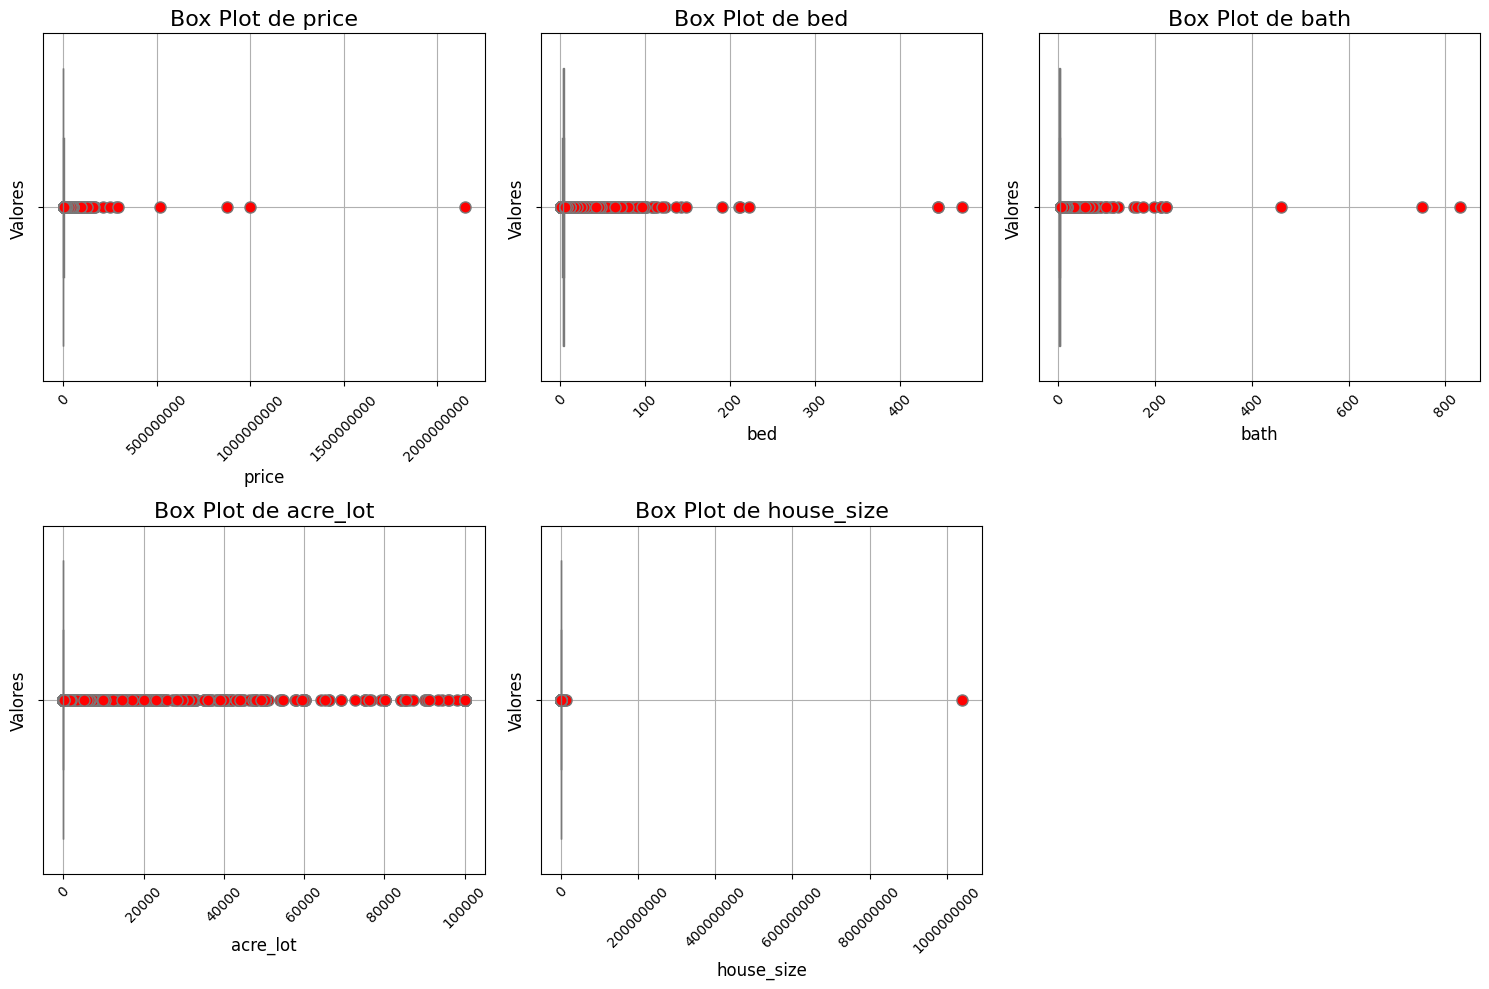

In [308]:
# Eliminación de outliers
box_plot_vars(df_cleaned)

In [309]:
# Eliminar valores que claramente son absurdos
# Segun san google, la casa mas pequeña del mundo es de 325 pies cuadrados, no puede ser que haya casas con 3 pies cuadrados
df_cleaned = df_cleaned[(df_cleaned['bed'] != 0) & (df_cleaned['bath'] != 0) & (df_cleaned['price'] > 0) & (df_cleaned['house_size'] > 300)]
# Eliminamos datos en los que el tamaño del lote es menor que el tamaño de la casa
df_cleaned = df_cleaned[df_cleaned['acre_lot'] * 43560 >= df_cleaned['house_size']]

df_cleaned = df_cleaned[df_cleaned['state'] != 3.0]
df_cleaned['state'] = df_cleaned['state'].astype(str)


df_cleaned['log_house_size'] = np.log(df_cleaned['house_size'])

df_cleaned = remove_outliers_iqr(df_cleaned, 'log_house_size')
df_cleaned = remove_outliers_zscore(df_cleaned, 'bath', 3)
df_cleaned = remove_outliers_zscore(df_cleaned, 'bed', 3)
df_cleaned = remove_outliers_iqr(df_cleaned, 'acre_lot')


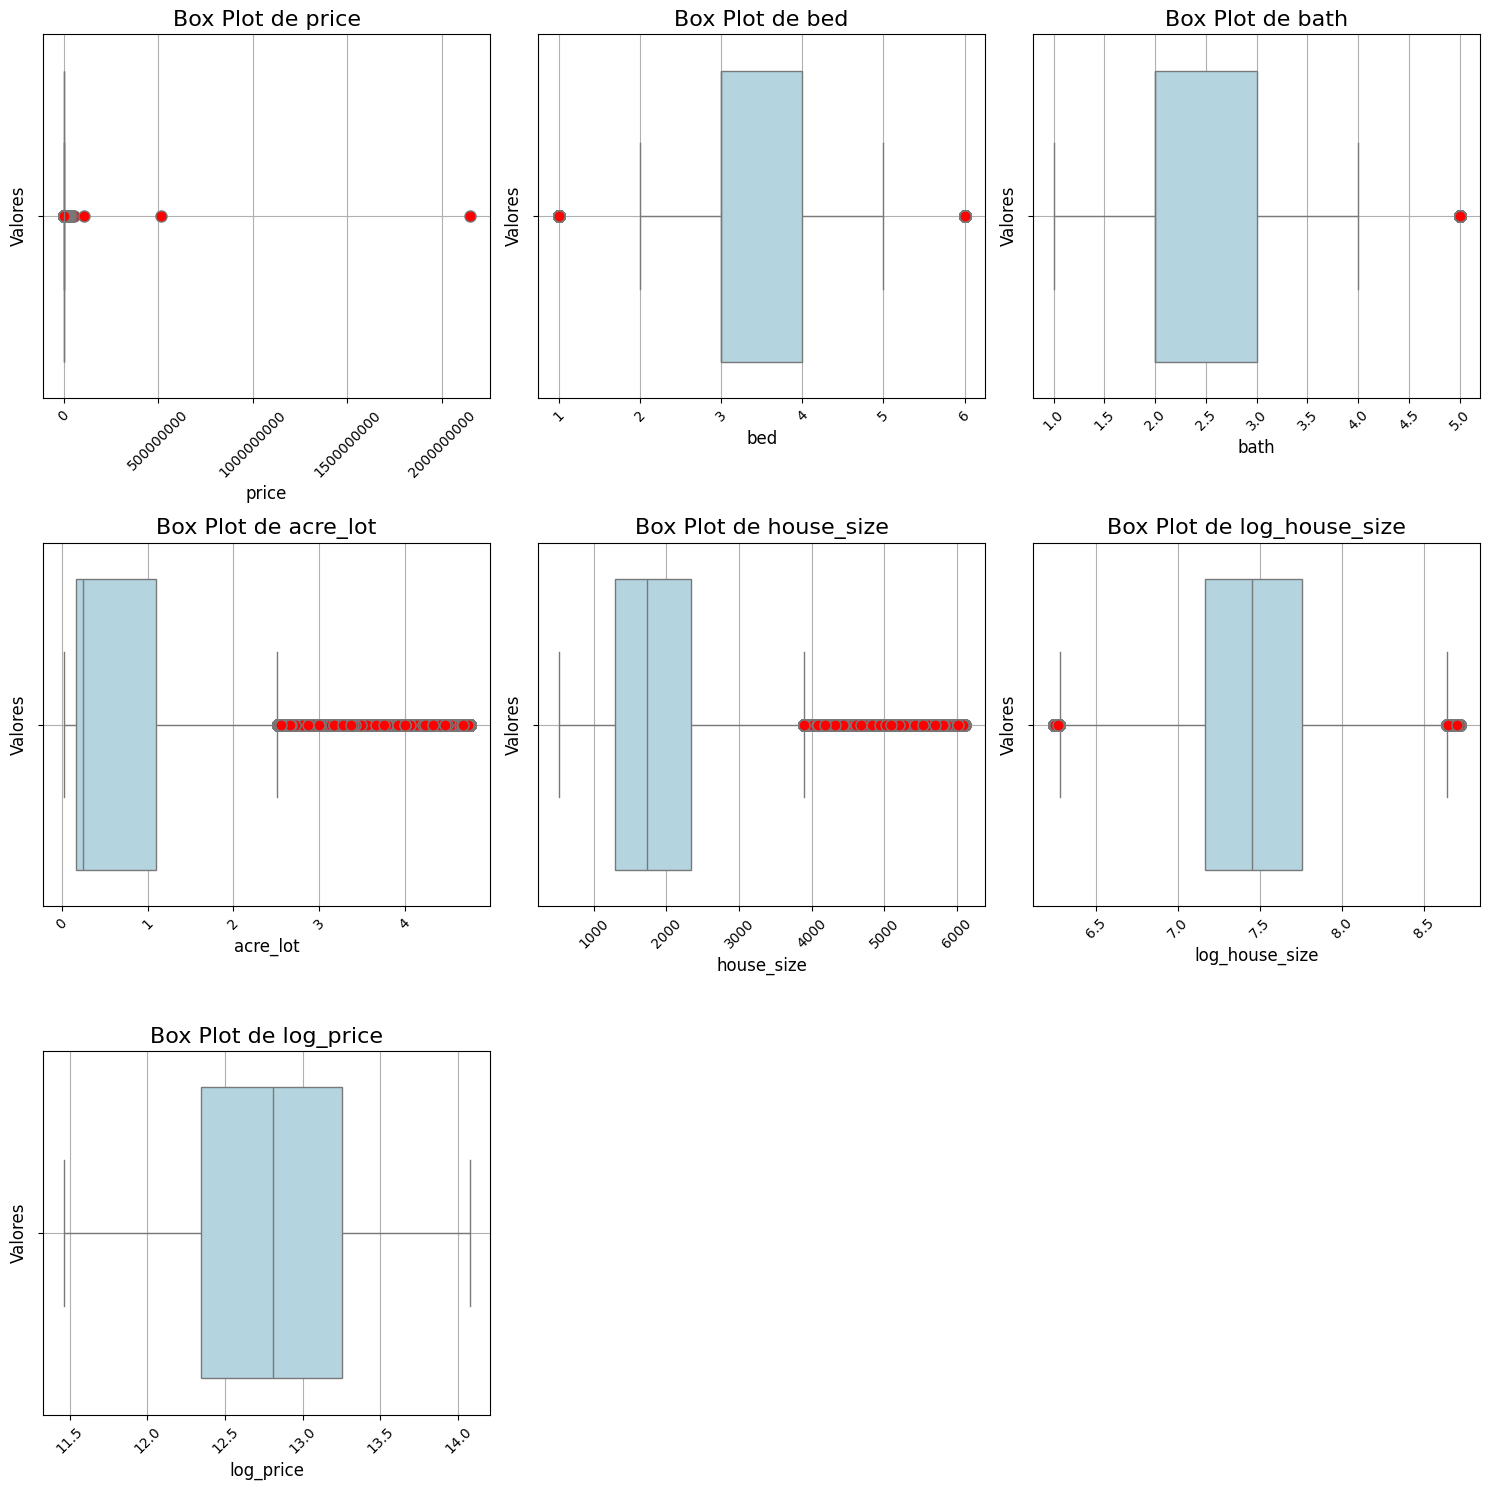

In [310]:
df_cleaned['log_price'] = np.log(df_cleaned['price'])
df_cleaned['log_price'] = mstats.winsorize(df_cleaned['log_price'], limits=[0.05, 0.05])
#df_cleaned = df_cleaned.drop(columns=['price', 'house_size', 'acre_lot'])
box_plot_vars(df_cleaned)

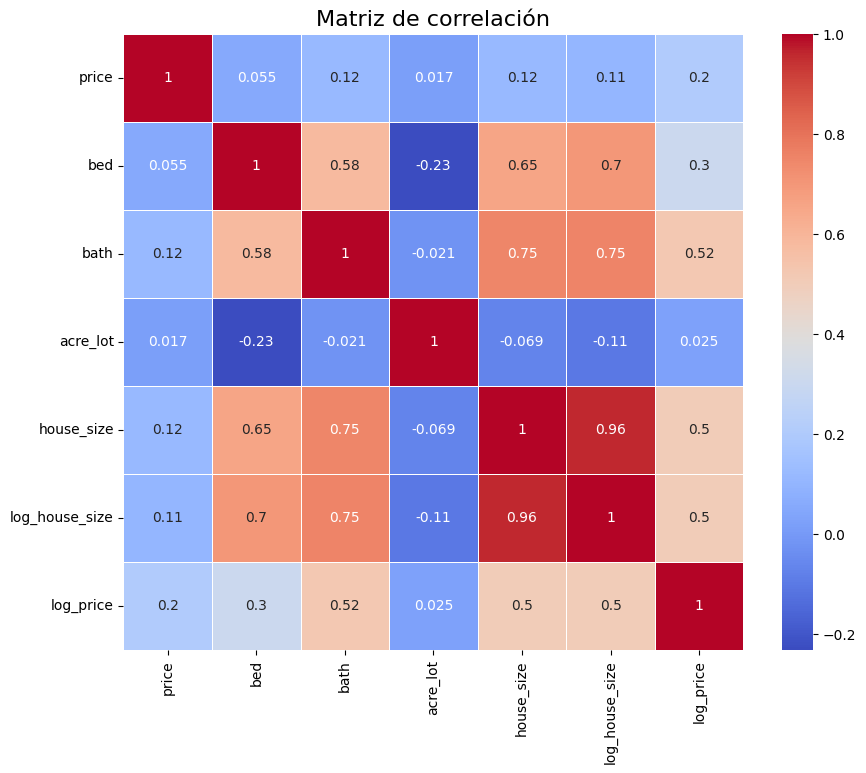

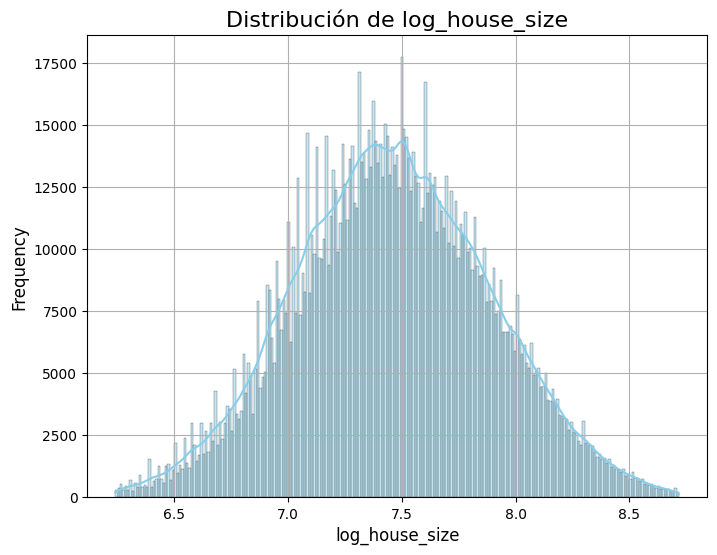

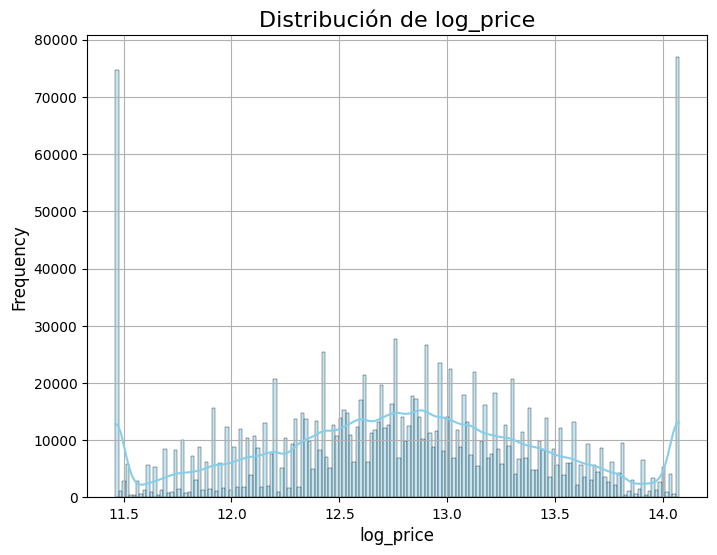

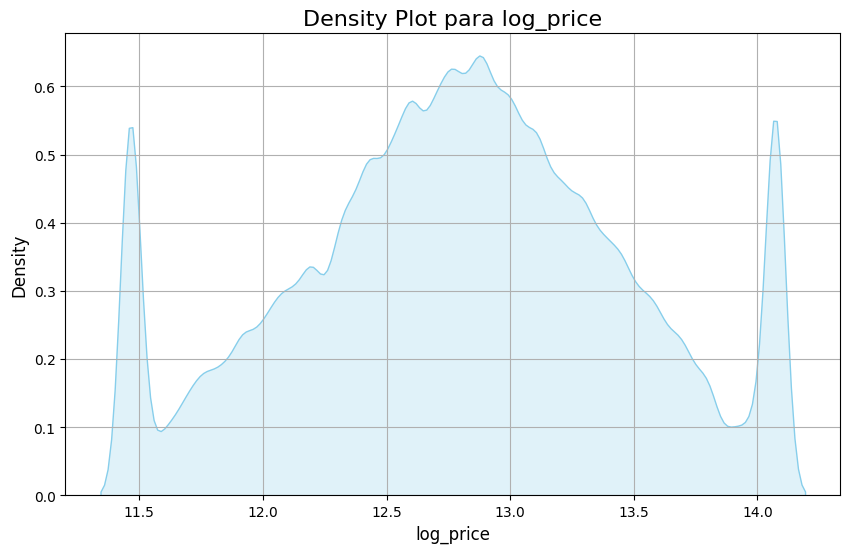

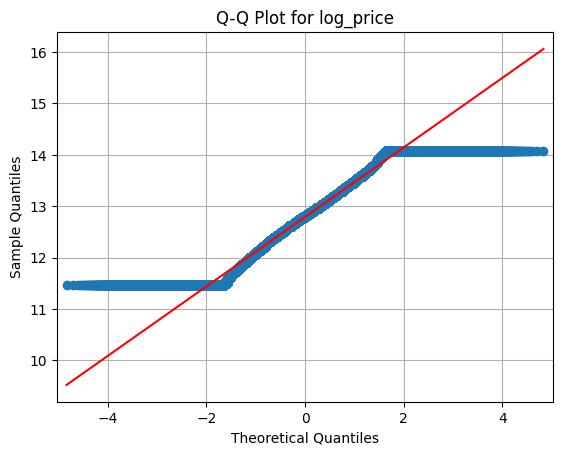

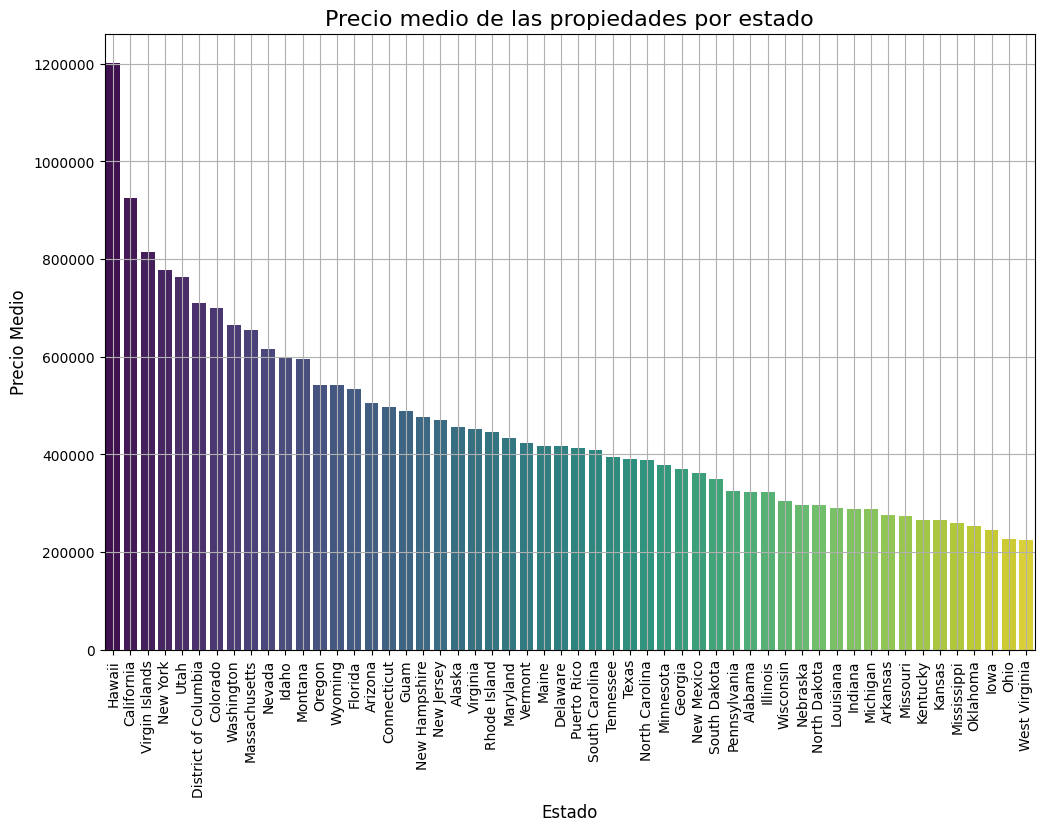

In [311]:
plot_correlation_matrix(df_cleaned)
col = ['log_house_size', 'log_price']

plot_histograms(df_cleaned, col)

plt.figure(figsize=(10, 6))
sns.kdeplot(df_cleaned['log_price'], fill=True, color='skyblue')
plt.title('Density Plot para log_price', fontsize=16)
plt.xlabel('log_price', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(True)
plt.show()

sm.qqplot(df_cleaned['log_price'], line='s')
plt.title('Q-Q Plot for log_price')
plt.grid(True)
plt.show()

plot_average_price_per_state(df_cleaned)

,price,log_price,state
0,105000.00,11.56,Puerto Rico
1,80000.00,11.46,Puerto Rico
2,67000.00,11.46,Puerto Rico
6,50000.00,11.46,Puerto Rico
7,71600.00,11.46,Puerto Rico
...,...,...,...
2224757,1250000.00,14.04,Washington
2224758,75000.00,11.46,Washington
2224765,1225000.00,14.02,Washington
2224810,90000.00,11.46,Washington


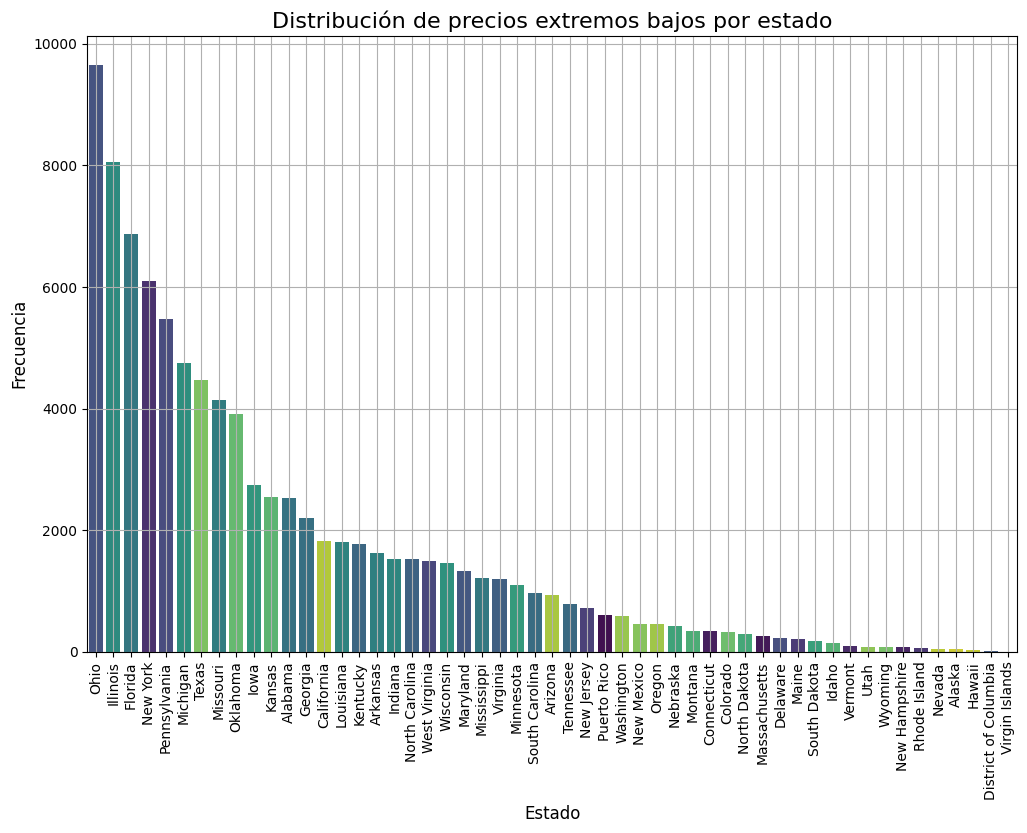

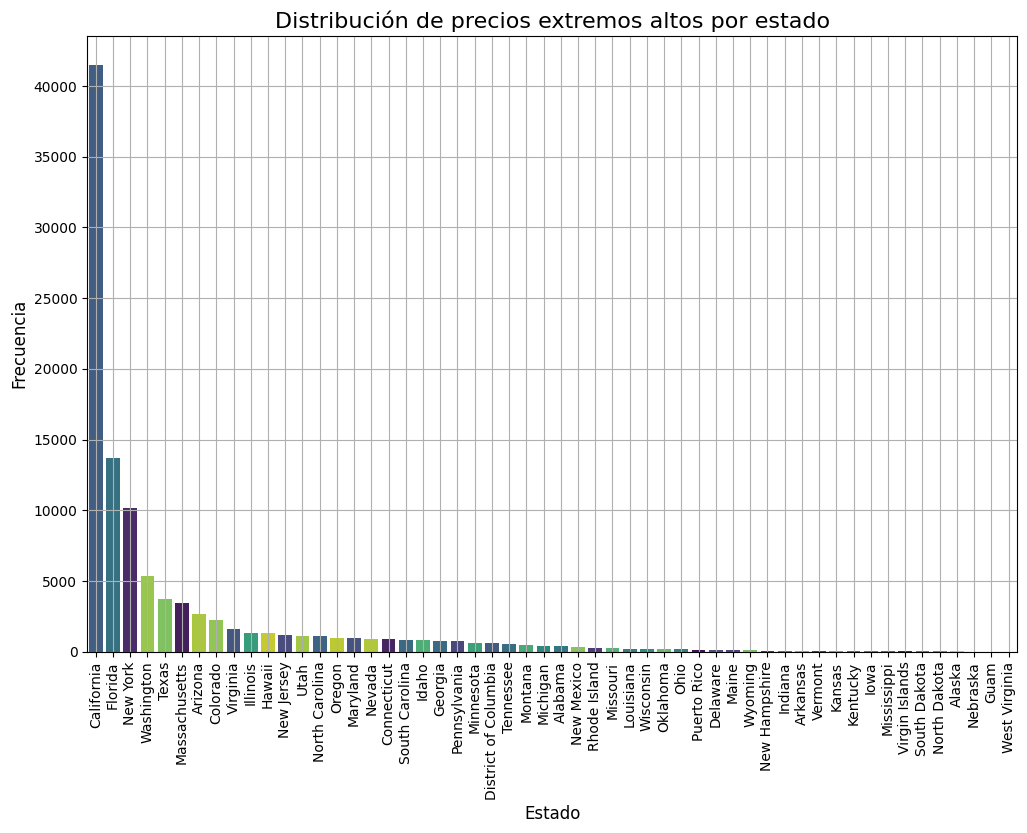

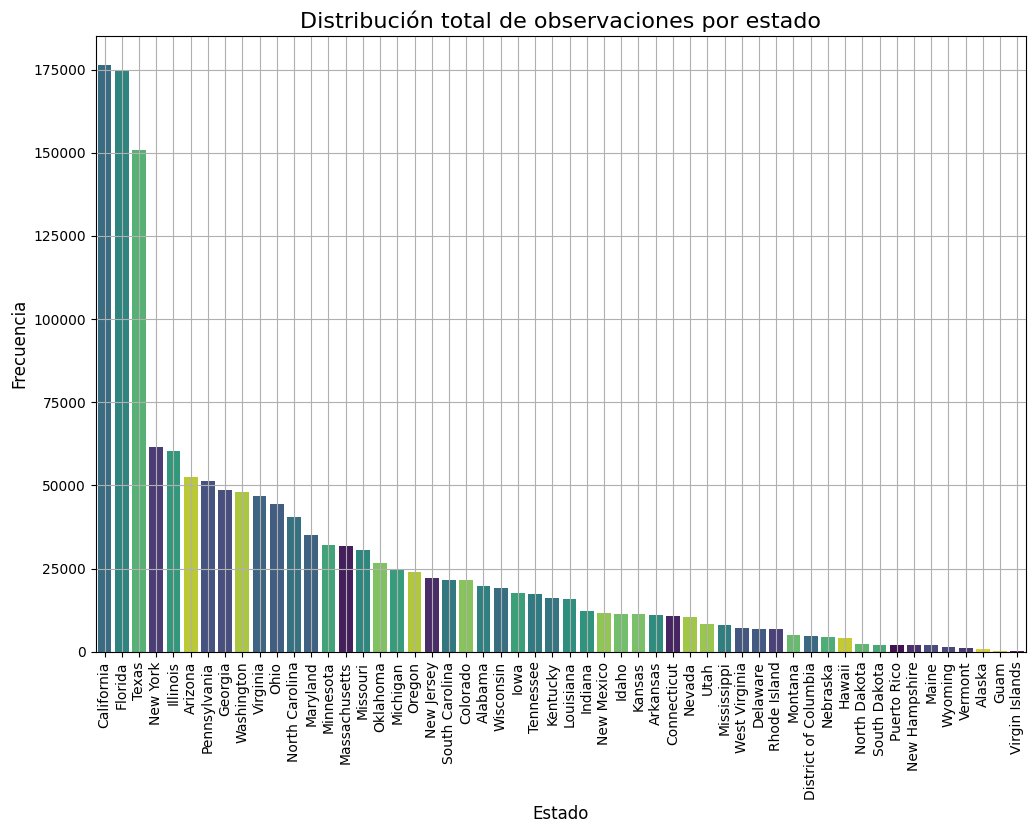

In [312]:
extreme_low = np.exp(11.6)  # Valor original correspondiente a log_price ~ 11.5
extreme_high = np.exp(13.9)  # Valor original correspondiente a log_price ~ 14.0
# Esto se estuvo variando para ver mas o menos que valores de extreme low y high me servian, pero no sirvio de mucho
# Mostrar las filas con esos valores extremos
df_extremes = df_cleaned[(df_cleaned['price'] <= extreme_low) | (df_cleaned['price'] >= extreme_high)]
display(df_extremes[['price', 'log_price', 'state']])
df_extremes.groupby('state').size().reset_index(name='frequency')

# Filtrar los datos extremos bajos y altos
df_extreme_low = df_cleaned[df_cleaned['price'] <= extreme_low]
df_extreme_high = df_cleaned[df_cleaned['price'] >= extreme_high]

# Muestra un grafico de barras para la distribucion por estado de precios extremos bajos
plot_state_distribution(df_extreme_low, 'state', 'Distribución de precios extremos bajos por estado')

# Muestra un grafico de barras para la distribucion por estado de precios extremos altos
plot_state_distribution(df_extreme_high, 'state', 'Distribución de precios extremos altos por estado')

# Muestra un grafico de barras para la distribucion por estado de todas las observaciones
plot_state_distribution(df_cleaned, 'state', 'Distribución total de observaciones por estado')


,state,var,count
0,Alabama,0.40,19845
1,Alaska,0.33,745
2,Arizona,0.26,52403
3,Arkansas,0.35,11039
4,California,0.29,176348
5,Colorado,0.28,21582
6,Connecticut,0.41,10884
7,Delaware,0.28,6905
8,District of Columbia,0.26,4735
9,Florida,0.40,174737


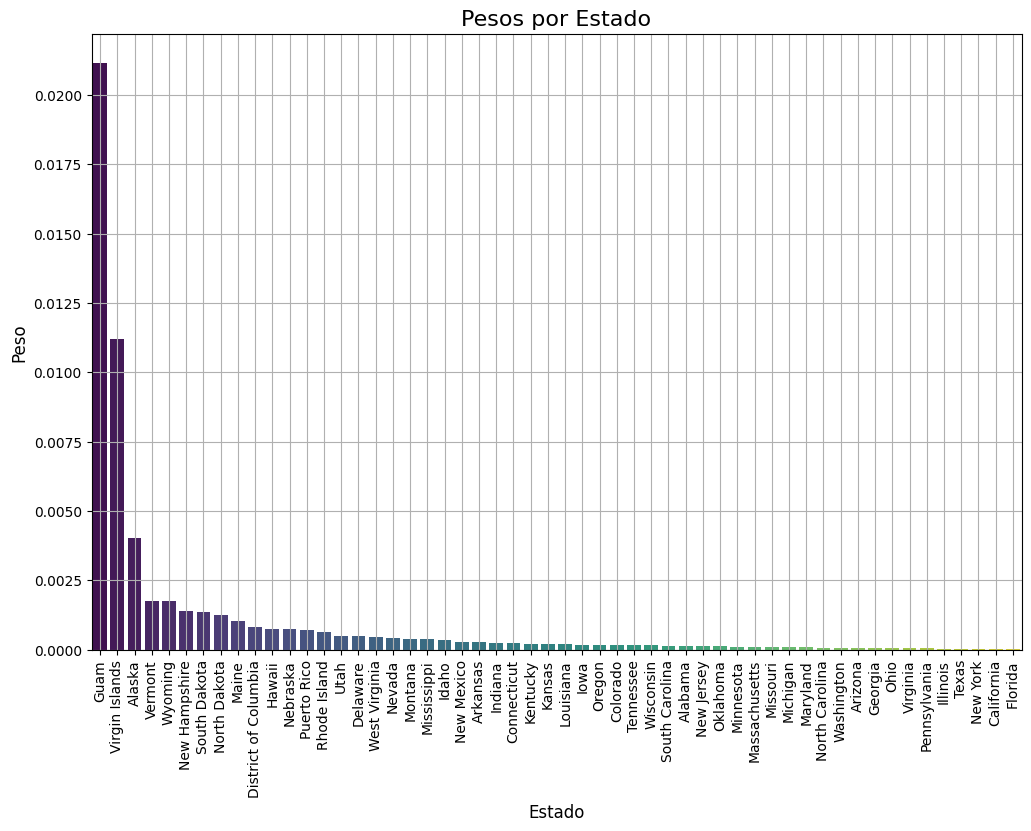

In [313]:
state_stats = df_cleaned.groupby('state')['log_price'].agg(['var', 'count']).reset_index()
display(state_stats)
#ponderación por varianza
state_stats['weight_var'] = 1 / state_stats['var']
state_stats['weight_geo'] = 1/ state_stats['count']
state_stats['weight'] = state_stats['weight_var'] * state_stats['weight_geo']
df_cleaned = df_cleaned.merge(state_stats[['state', 'weight']], on='state', how='left')

weights_by_state = df_cleaned.groupby('state')['weight'].max().sort_values(ascending=False).reset_index()

# Crear el gráfico de barras para los pesos por estado
plt.figure(figsize=(12, 8))
sns.barplot(data=weights_by_state, x='state', y='weight', hue='state', palette='viridis')
plt.title('Pesos por Estado', fontsize=16)
plt.xlabel('Estado', fontsize=12)
plt.ylabel('Peso', fontsize=12)
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


In [314]:

df_cleaned_dummies = pd.get_dummies(df_cleaned, columns=['state'], drop_first=True)
X_dum = df_cleaned_dummies.drop(columns=['price', 'log_price', 'status', 'prev_sold_date', 'weight', 'house_size', 'city'])
y_dum = df_cleaned_dummies['log_price']
weights = df_cleaned['weight']
fit_ols_wls(X_dum, y_dum, weights)

Resumen WLS:
                             WLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.615
Model:                            WLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                 4.148e+04
Date:               do., 06 oct. 2024   Prob (F-statistic):               0.00
Time:                        08:27:57   Log-Likelihood:            -1.2769e+06
No. Observations:             1480400   AIC:                         2.554e+06
Df Residuals:                 1480342   BIC:                         2.555e+06
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const 

In [316]:
X_size = df_cleaned_dummies.drop(columns=['price', 'log_price', 'status', 'prev_sold_date', 'weight', 'house_size', 'city', 'bed', 'bath', 'acre_lot'])
y_size = df_cleaned_dummies['log_price'].loc[X_size.index]
fit_ols_wls(X_size, y_size, weights)

Resumen WLS:
                             WLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.573
Model:                            WLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                 3.684e+04
Date:               do., 06 oct. 2024   Prob (F-statistic):               0.00
Time:                        08:28:07   Log-Likelihood:            -1.3529e+06
No. Observations:             1480400   AIC:                         2.706e+06
Df Residuals:                 1480345   BIC:                         2.707e+06
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const 

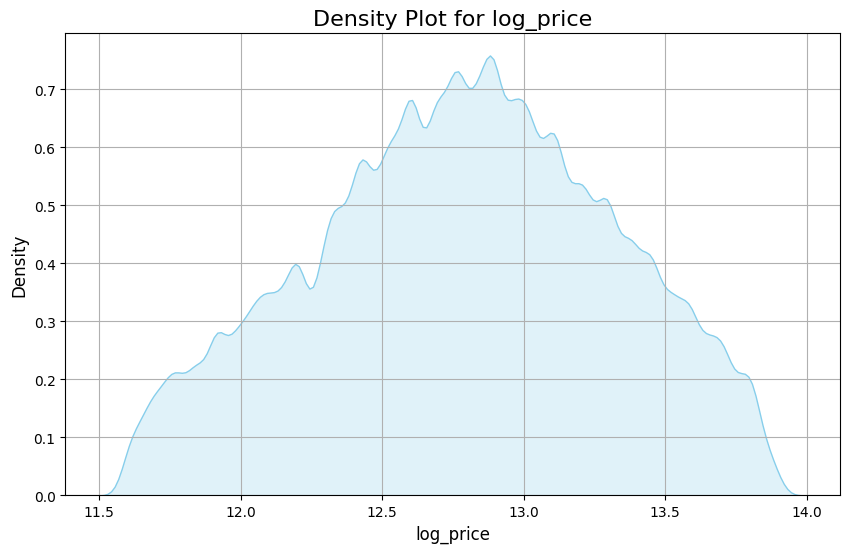

Resumen WLS:
                             WLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.546
Model:                            WLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                 2.718e+04
Date:               do., 06 oct. 2024   Prob (F-statistic):               0.00
Time:                        08:28:25   Log-Likelihood:            -9.0427e+05
No. Observations:             1287388   AIC:                         1.809e+06
Df Residuals:                 1287330   BIC:                         1.809e+06
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const 

In [317]:
# Queria ver si mejoraba algo quitando los picos, pero no mejora nada
df_extremes_cleaned = df_cleaned[(df_cleaned['price'] > extreme_low) & (df_cleaned['price'] < extreme_high)]
#df_cleaned_no_california_no_ohio = df_cleaned[(df_cleaned['state'] != 'California') & (df_cleaned['state'] != 'Ohio')].copy()
df_extremes_cleaned_dum = pd.get_dummies(df_extremes_cleaned, columns=['state'], drop_first=True)
X_cs = df_extremes_cleaned_dum.drop(columns=['price', 'log_price', 'status', 'prev_sold_date', 'weight', 'house_size', 'city'])
y_cs = df_extremes_cleaned_dum['log_price']
weights_cd = df_extremes_cleaned_dum['weight']

plt.figure(figsize=(10, 6))
sns.kdeplot(df_extremes_cleaned_dum['log_price'], fill=True, color='skyblue')
plt.title('Density Plot for log_price', fontsize=16)
plt.xlabel('log_price', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(True)
plt.show()

fit_ols_wls(X_cs, y_cs, weights_cd)

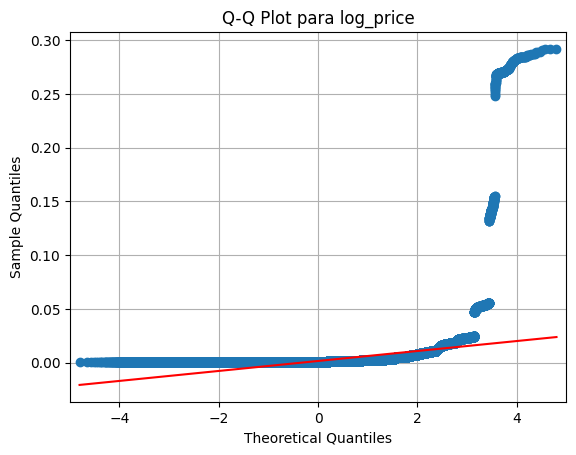

In [318]:
# Nota, aca me puse a mover los valores de los extremos para ver si se podia mejorar el modelo, se miraba raro y ahi lo deje
sm.qqplot(df_extremes_cleaned['log_price'] * df_extremes_cleaned['weight'], line='s')
plt.title('Q-Q Plot para log_price')
plt.grid(True)
plt.show()